In [3]:
import sys
get_ipython().system('{sys.executable} -m pip install --quiet numpy pandas matplotlib seaborn scikit-learn')

# Color Moments

In [20]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, pairwise_distances
from collections import defaultdict, Counter
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from PIL import Image



# Setup

## Descrizione della funzione `crop_to_brain()`

Questa funzione prevede i seguenti passaggi principali:

1. **Conversione in scala di grigi:** semplifica l’immagine riducendola a un solo canale di intensità luminosa.
2. **Applicazione di una soglia binaria:** vengono considerati significativi solo i pixel con intensità superiore a **10** (per eliminare il nero dello sfondo).
3. **Calcolo del bounding box:** viene individuato il rettangolo più piccolo che contiene tutti i pixel significativi.
4. **Ritaglio dell’immagine:** l’immagine viene ritagliata lungo i bordi del bounding box, lasciando solo l’area cerebrale.

---

## Obiettivo della pre-elaborazione

L’obiettivo di questa fase è **standardizzare l’area di interesse** all’interno delle immagini e **rimuovere le parti non informative**.  
Questo porta a una serie di vantaggi importanti:

- ✅ **Migliora la qualità dei descrittori:** eliminando il rumore dei bordi non rilevanti.
- ✅ **Standardizza posizione e dimensione:** le immagini risultano più simili dal punto di vista geometrico.
- ✅ **Riduce la variabilità non utile:** rende i confronti tra immagini più affidabili.

---

## Output della funzione

La funzione restituisce una **nuova immagine**, che può avere dimensioni variabili in base al contenuto ritagliato.

Questa immagine verrà utilizzata successivamente nei task di estrazione dei descrittori visivi.

In [5]:
def crop_to_brain(img):
    """Ritaglia l'area informativa (cervello) da un'immagine."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return img[y:y+h, x:x+w]
    return img  # fallback

In [6]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "color_moments_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "color_moments_part2.npz")



# Task 1-2

## Implementa un programma che **estrae e memorizza i descrittori di feature** per tutte le immagini nel set di dati.

## Estrazione dei Color Moments**

Dopo aver ritagliato la porzione utile dell’immagine, vogliamo rappresentare numericamente le sue caratteristiche visive tramite **Color Moments**.

### **Cos'è un Color Moment?**

Per ogni canale colore (R, G, B) calcoliamo 3 statistiche **per ogni regione dell’immagine**:
- **Media (Mean):** indica il colore medio.
- **Deviazione standard (Std):** misura la variabilità dei colori (contrasto).
- **Skewness (Assimmetria):** misura lo sbilanciamento della distribuzione dei colori verso valori più chiari o più scuri.

Queste tre statistiche catturano l’aspetto cromatico di una porzione dell’immagine.

---

### **Suddivisione dell'immagine in una griglia 10×10**

Per non perdere le informazioni spaziali, suddividiamo l’immagine in una **griglia 10×10**:
- Ogni cella della griglia corrisponde a una porzione locale dell’immagine.
- I Color Moments vengono calcolati separatamente per ciascuna cella.

### **Output finale**

Per ogni cella vengono calcolati:
- 3 valori per R (mean, std, skewness)
- 3 valori per G
- 3 valori per B

Totale: **3 statistiche × 3 canali × 100 celle = 900 feature per immagine**

Queste 900 feature rappresentano **numericamente l’intera immagine**, mantenendo sia l’informazione cromatica che quella spaziale.

---

## **Vantaggi dei Color Moments**

- **Calcolo semplice:** molto più rapido rispetto a descrittori complessi come SIFT o SURF.
- **Informazioni significative:** nei contesti medici, i colori possono evidenziare strutture anomale.
- **Rappresentazione locale:** grazie alla suddivisione in celle, preserviamo anche informazioni spaziali.
- **Efficienza computazionale:** perfetto per dataset medi o grandi.

---

## 🔬 **Considerazioni finali per Task 1-2**

Dopo questa fase abbiamo per ogni immagine:
- Un’area cerebrale ritagliata e priva di rumore di background.
- Un vettore numerico di **900 feature**, pronto per il confronto tra immagini e per l’uso in algoritmi di Machine Learning.

Il passo successivo sarà salvare questi descrittori in formato efficiente (`.npz`) e utilizzarli nei task successivi per la ricerca e la classificazione.

In [7]:
def extract_color_moments(img_path):
    """Estrae Color Moments su una griglia 10x10 da un'immagine."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata: {img_path}")
        return None

    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = crop_to_brain(img)
    img = cv2.resize(img, (300, 100))  # Griglia uniforme

    h, w, _ = img.shape
    grid_h, grid_w = h // 10, w // 10
    features = []

    # Scorri ogni cella della griglia (10 righe e 10 colonne)
    for i in range(10):
        for j in range(10):
            # Estrae la porzione di immagine corrispondente alla cella (slice dell'immagine)
            cell = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]

            # Per ogni canale di colore (Blue, Green, Red)
            for channel in range(3):
                # Estrae i pixel della cella e del canale specifico, appiattendo il risultato in un vettore 1D
                pixels = cell[:, :, channel].flatten()

                # Se la cella ha variazione cromatica (deviazione standard > 0), calcola i Color Moments
                if np.std(pixels) > 0:
                    mean = np.mean(pixels)   # Media dei pixel → rappresenta il colore medio
                    std = np.std(pixels)    # Deviazione standard → rappresenta la variazione di colore
                    sk = skew(pixels)       # Skewness (asimmetria) → indica se i pixel sono più scuri o chiari

                    # In alcuni casi il calcolo della skewness può produrre NaN (non numerico); lo sostituiamo con 0
                    if np.isnan(sk):
                        sk = 0
                else:
                    # Se i pixel sono tutti uguali, mettiamo 0 per tutti i descrittori per evitare divisioni per zero
                    mean, std, sk = 0, 0, 0

                # Aggiungiamo i tre valori calcolati (mean, std, skew) alla lista delle feature
                features.extend([mean, std, sk])

    # Ritorna il vettore delle feature Color Moments estratto da tutta l’immagine
    return features

In [8]:
def process_and_save_features(base_folder, subfolders, output_file):
    """Estrae le feature da immagini organizzate in sottocartelle e le salva in un file .npz."""
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_color_moments(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    print(f"[SALVATO] Features salvate in {output_file}")

In [ ]:
# Parametri
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "color_moments_part1.npz")
process_and_save_features("Part2", subfolders, "color_moments_part2.npz")

### Task 3

Implementa un programma che, **dato il **nome di un file immagine** e un valore "k"**, **restituisce e visualizza le k immagini più simili** in base a ciascun modello visivo

# 🔍 Task 3 – Retrieval di Immagini Mediche Basato sui Color Moments

## Obiettivo

In questo task implementiamo un **sistema di retrieval**, ossia un metodo per **trovare le immagini più simili** a una data immagine di query, basandoci sulle **feature estratte (Color Moments)**.

Questa procedura è fondamentale per:
- Identificare rapidamente immagini simili in grandi dataset.
- Analizzare quali immagini hanno caratteristiche visive più vicine tra loro.
- Supportare l’analisi diagnostica trovando casi simili a quello in esame.

---

### **Funzione principale: `find_k_similar_unified()`**

Questa funzione automatizza i seguenti passaggi:


**Estrazione delle feature della query**

In questo modo query e dataset sono nello stesso spazio vettoriale e possono essere confrontati.

**Calcolo della distanza tra feature**

Per determinare la similarità tra immagini possiamo scegliere **due diverse metriche di distanza**:

####  a) Distanza Euclidea
- Formula classica della distanza geometrica tra vettori.
- **Veloce da calcolare**, ma non tiene conto della varianza delle singole feature.


####  b)  Distanza di Mahalanobis
- Tiene conto della covarianza tra le feature, normalizzando i contributi di ogni dimensione.
- Più robusta, considera la distribuzione statistica dei dati.

**Esclusione della query stessa dai risultati**

Se la query è già presente nel dataset, viene esclusa dal risultato per evitare che venga restituita come immagine più simile a sé stessa.
Nel codice, questo viene fatto impostando la distanza dell’immagine query a infinito.

**Ordinamento dei risultati**

Le immagini vengono ordinate in base alla distanza calcolata e vengono selezionati i k risultati più vicini:

**Visualizzazione dei risultati**

---

### Analisi Dei Risultati:
- La distanza euclidea ha un forte incremento nella distanza tra i primi risultati e quelli successivi, segno che la Euclidea non gestisce bene la variabilità interna delle feature.
-  La distanza Mahalanobis fornisce una valutazione più equilibrata e statisticamente coerente, individuando immagini simili dal punto di vista statistico, anche se appartengono a classi diverse
- La distanza Mahalanobis è più adatta quando vogliamo capire quali immagini hanno una distribuzione delle feature simile, anche se appartengono a classi diverse.


In [10]:
def find_k_similar_unified(base_folder, img_path, k, distance_type="euclidean"):
    """
    Trova le k immagini più simili a una query utilizzando distanza euclidea o Mahalanobis.
    
    Args:
        base_folder (str): Cartella base in cui cercare le immagini.
        img_path (str): Percorso immagine query.
        k (int): Numero di immagini da restituire.
        distance_type (str): Tipo di distanza ('euclidean' o 'mahalanobis').
    """
    # Estrai le feature dalla query
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    if distance_type == "euclidean":
        distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()

    elif distance_type == "mahalanobis":
        # Calcola matrice di covarianza e la sua inversa
        cov = np.cov(feat_matrix_part1.T)
        try:
            cov_inv = np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            print("[ERRORE] Uso pseudoinversa per matrice non invertibile.")
            cov_inv = np.linalg.pinv(cov)

        query_feature = query_feature.flatten()
        distances = np.array([mahalanobis(query_feature, f, cov_inv) for f in feat_matrix_part1])

        # Escludi la query stessa se già presente
        query_filename = os.path.basename(img_path)
        query_label = os.path.basename(os.path.dirname(img_path))
        for i in range(len(flname_part1)):
            if flname_part1[i] == query_filename and lbls_part1[i] == query_label:
                distances[i] = np.inf
                break
    else:
        print(f"[ERRORE] Tipo di distanza non supportato: {distance_type}")
        return

    # Trova i top-k
    top_k_idx = np.argsort(distances)[:k]

    # Output testuale
    print(f"\nTop {k} immagini simili a: {img_path} (Distanza: {distance_type})")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank + 1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {distances[idx]:.2f}")

    # Visualizzazione immagini
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match_path = os.path.join(base_folder, lbls_part1[idx], flname_part1[idx])
        img_match = cv2.imread(img_match_path)
        axs[i + 1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i + 1].set_title(f"Rank {i + 1}\nD={distances[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
base_folder = "Part1"
img_path = "Part1/brain_glioma/brain_glioma_0005.jpg"

find_k_similar_unified(base_folder, img_path, k=5, distance_type="euclidean")
find_k_similar_unified(base_folder, img_path, k=5, distance_type="mahalanobis")

# Task 4 – Confronto tra Strategie di Classificazione Basate su Distanze

 Implementa un programma che, dati:
- (a) un'immagine di query della **Parte 2**,
- (b) uno **spazio di feature** selezionato dall'utente,
- (c) un numero intero positivo **k**,

identifichi ed elenchi le **k etichette di corrispondenza più probabili**, insieme ai loro punteggi, calcolati nello **spazio di feature selezionato**.

### Definizioni

**Feature space:** spazio vettoriale in cui ogni immagine è rappresentata come un **vettore di caratteristiche** (feature vector).

**Selected feature space:** indica **il tipo di caratteristiche** estratte per rappresentare le immagini (es. color moments, HOG, deep features, ecc.).

## Obiettivo

In questo task implementiamo un confronto tra **due diverse strategie di classificazione**, entrambe basate sulle distanze tra la query e le immagini del dataset.  

L’obiettivo è capire a quale **classe** appartiene una immagine query analizzando le sue **feature (Color Moments)** e confrontandole con quelle delle classi note.

---

## Descrizione del codice

### 1️: Estrazione delle feature della query

### 2: **Strategia 1: Distanza media per classe**

#### Descrizione
- Viene calcolata la **distanza Euclidea** tra la query e tutte le immagini del dataset.
- Per ogni **classe**, viene calcolata la **media delle distanze** tra la query e tutte le immagini appartenenti a quella classe.

#### Vantaggi:
- Tiene conto di **tutte le immagini** della classe.
- Robusta nei confronti di rumore casuale nelle singole immagini.

#### Svantaggi:
- **Sensibile agli outlier**: immagini anomale possono aumentare la distanza media della classe.

### 3: **Strategia 2: Distanza dal prototipo della classe**

#### Descrizione
- Per ogni classe viene calcolato il **prototipo**, ovvero il **centroide** (media vettoriale) delle feature di tutte le immagini della classe.
- Si calcola la distanza Euclidea tra la query e il **centroide** di ogni classe.

#### Vantaggi:
- **Robusto agli outlier**, perché ogni classe è rappresentata da un solo vettore medio.
- Più veloce da calcolare.

#### Svantaggi:
- Potrebbe non rappresentare bene le **sottostrutture interne** della classe.
- Se la query è simile solo ad un sottogruppo della classe, ma distante dal centroide, questa strategia può dare un risultato meno preciso.

### 4️: Visualizzazione dei risultati

Questo confronto aiuta a capire quale strategia restituisce la classe più vicina alla query.

### 5️: Analisi automatica del miglior risultato

La funzione confronta i risultati delle due strategie e segnala se **entrambi i metodi identificano la stessa classe**.  
In caso contrario, suggerisce la strategia che ha ottenuto la distanza più bassa.

---

## 🧠 Analisi dei risultati

- La **strategia con il centroide** fornisce distanze più basse e quindi una rappresentazione più efficace del contenuto medio della classe.
- Entrambe le strategie concordano sulla classe corretta, ma il centroide è più rappresentativo in termini numerici.

## Confronto tra le due strategie

| Strategia               | Punti di forza                                  | Limiti                                    |
|-------------------------|--------------------------------------------------|------------------------------------------|
| Media per classe        | Considera tutte le immagini                      | Sensibile agli outlier                   |
| Prototipo (centroide)   | Robusto agli outlier, semplice da calcolare      | Può non catturare sottogruppi specifici  |


In [46]:
def compare_label_ranking_strategies(query_img_path, k=2):
    """
    Confronta le etichette predette da due strategie:
    - distanza media per classe
    - distanza al rappresentante (prototipo) della classe
    Visualizza solo le top-k etichette con un grafico comparativo.
    Inoltre stampa quale strategia sembra migliore in base alla distanza top-1.
    """
    assert k <= 2, "k deve essere <= 2"

    query_feature = extract_color_moments(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # ===== Strategia 1: distanza media per classe =====
    distances_all = euclidean_distances(feat_matrix_part1, query_feature).flatten()
    df_all = pd.DataFrame({
        'label': lbls_part1,
        'distance': distances_all
    })
    mean_dists = df_all.groupby('label')['distance'].mean().sort_values()

    # ===== Strategia 2: distanza dal prototipo (centroide) =====
    df_features = pd.DataFrame(feat_matrix_part1)
    df_features['label'] = lbls_part1
    class_prototypes = df_features.groupby('label').mean().drop(columns=['label'], errors='ignore')
    proto_vectors = class_prototypes.values
    proto_labels = class_prototypes.index
    proto_dists = euclidean_distances(proto_vectors, query_feature).flatten()
    proto_dists_series = pd.Series(proto_dists, index=proto_labels).sort_values()

    # ===== Prendi le top-k etichette comuni =====
    top_k_mean = mean_dists.head(k)
    top_k_proto = proto_dists_series.head(k)

    union_labels = sorted(set(top_k_mean.index).union(set(top_k_proto.index)))

    # ===== Plot solo per le top-k etichette =====
    x = np.arange(len(union_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, [mean_dists[label] for label in union_labels], width, label='Distanza Media')
    ax.bar(x + width/2, [proto_dists_series[label] for label in union_labels], width, label='Distanza Prototipo')

    ax.set_ylabel('Distanza')
    ax.set_title(f"Top-{k} Strategie - Query: {os.path.basename(query_img_path)}")
    ax.set_xticks(x)
    ax.set_xticklabels(union_labels)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Stampa i top-k risultati =====
    print("\n Top-k etichette per ciascuna strategia:\n")
    print("Strategia: Distanza Media")
    print(top_k_mean)

    print("\n Strategia: Prototipo di Classe")
    print(top_k_proto)

    # ===== Confronto top-1 =====
    top1_mean_label = top_k_mean.index[0]
    top1_mean_value = top_k_mean.iloc[0]
    top1_proto_label = top_k_proto.index[0]
    top1_proto_value = top_k_proto.iloc[0]

    print("\n==== Analisi della Strategia Migliore ====")
    if top1_mean_label == top1_proto_label:
        print(f"[OK] Entrambe le strategie concordano sulla classe '{top1_mean_label}'.")
        print(f" → Distanza media: {top1_mean_value:.4f}, distanza prototipo: {top1_proto_value:.4f}")
    else:
        print(f"[DIFFERENZA] Le strategie danno risultati diversi:")
        print(f" - Distanza Media: '{top1_mean_label}' con distanza {top1_mean_value:.4f}")
        print(f" - Prototipo: '{top1_proto_label}' con distanza {top1_proto_value:.4f}")
        if top1_mean_value < top1_proto_value:
            print(f" → [SCELTA SUGGERITA] Preferibile 'Distanza Media' ({top1_mean_label})")
        else:
            print(f" → [SCELTA SUGGERITA] Preferibile 'Prototipo' ({top1_proto_label})")

In [ ]:
query_img = "Part2/brain_glioma/brain_glioma_1142.jpg"
compare_label_ranking_strategies(query_img, k=2)

# Task 5: Estrazione delle Semantiche Latenti

Implementa un programma che, dati:
- (a) uno dei modelli di feature disponibili,
- (b) un valore **k** specificato dall'utente,
- (c) una delle tre tecniche di riduzione della dimensionalità (**SVD**, **LDA**, **k-means**) scelta dall'utente,

estragga le **prime k semantiche latenti** dallo spazio delle feature selezionato.

### Funzionalità richieste

- **Memorizzare** le semantiche latenti estratte in un file di output, **adeguatamente nominato**.
- **Elencare** per ogni componente latente le **coppie (imageID, peso)** ordinate in ordine decrescente di peso.


### Definizione del feature model

Il **feature model** è un file contenente la rappresentazione delle feature di tutte le immagini del dataset, salvato come matrice (`feature_matrix`).  
La matrice ha dimensioni **n × d**, dove:
- **n** = numero di immagini,
- **d** = numero di feature.

Esempio di feature model: `color_moments.npz`.

---

## Procedura

### Input
- Un **feature model** (es. `color_moments.npz`).
- Un valore **k** che indica il numero di componenti latenti da estrarre.
- Una tecnica di riduzione dimensionale (**SVD**, **LDA**, o **k-means**).

### Operazioni
1. **Riduzione dimensionale** del feature space selezionato tramite la tecnica scelta.
2. **Estrazione delle top-k componenti latenti**.
3. Per ogni componente:
   - Calcolare i **pesi** associati a ogni immagine.
   - Ordinare le coppie **(imageID, peso)** in ordine decrescente di peso.

4. **Salvare i risultati** in un file di testo con nome descrittivo, ad esempio:  
   `latent_semantics_svd_color_moments_k3.txt`.

---

## Significato di **k**

| Tecnica   | Significato di k                                           |
|-----------|------------------------------------------------------------|
| **SVD**   | Numero di componenti principali → riduzione mantenendo la variazione globale. |
| **LDA**   | Numero di direzioni discriminanti → riduzione focalizzata sulla separazione tra le classi. |
| **k-means** | Numero di cluster → suddivisione delle immagini in gruppi simili (senza usare le etichette). |

In [14]:

def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D delle immagini nello spazio latente (solo per SVD/LDA)."""
    print(f"[DEBUG] Shape X_svd (dati trasformati): {X_transformed.shape}")
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza le immagini raggruppate da KMeans su uno spazio 2D ridotto con SVD."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.show()

def task5_latent_semantics(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature usando SVD, LDA o KMeans.
    Visualizza lo spazio latente ed esporta un file .txt con i pesi associati alle immagini.
    """

    technique = technique.lower()
    method = ""
    X_transformed = None
    components = None

    if technique == "svd":
        model = TruncatedSVD(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # Visualizzazione
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)

# Creazione output
    output_dir = os.path.join("task5_output", "latent_semantics_color_moments")
    os.makedirs(output_dir, exist_ok=True)
    
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = os.path.join(output_dir, f"latent_semantics_{method}_{base_name}_k{k}.txt")

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feat_matrix_part1 @ components[i].T
                sorted_idx = np.argsort(-np.abs(weights))
            else:  # KMeans: distanza dal centroide, più piccola = più vicino
                weights = -X_transformed[:, i]
                sorted_idx = np.argsort(weights)

            for idx in sorted_idx:
                image_id = flname_part1[idx]
                f.write(f"{image_id} | Peso: {weights[idx]:.4f} | Classe: {lbls_part1[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")  

In [ ]:
n_components=min(feat_matrix_part1.shape)

task5_latent_semantics("color_moments.npz", technique="svd", k=2)
#task5_latent_semantics("color_moments.npz", technique="svd", k=n_components)
task5_latent_semantics("color_moments.npz", technique="lda", k=2)
task5_latent_semantics("color_moments.npz", technique="kmeans", k=7)

---

### explained = pca.explained_variance_ratio_
es. explained = [0.40, 0.30, 0.20, 0.07, 0.03]

Un **array di float** dove ciascun **valore rappresenta la percentuale di varianza spiegata da ciascuna componente principale della PCA**.
È ordinato dalla componente più importante a quella meno importante.

Significa che **la prima componente spiega il 40% della varianza**, la seconda il 30%, ecc.

### cumulative = np.cumsum(explained)
es:cumulative = [0.40, 0.70, 0.90, 0.97, 1.00]

Calcola la somma cumulativa dell’array explained, cioè la **varianza totale spiegata fino a ciascuna componente**.

Significa:
- Le prime 2 componenti spiegano il 70%
- Le prime 3 il 90%
- Le prime 4 il 97%, ecc.

### intrinsic_dim = np.argmax(cumulative >= threshold) + 1

Questa riga:
	- Trova il primo indice in cui la varianza cumulativa raggiunge o supera una soglia (threshold), ad esempio 0.95 (95%).
	- np.argmax(...) restituisce il primo True nella condizione cumulative >= threshold.
	- Si aggiunge +1 perché gli indici Python partono da 0, ma il numero di componenti parte da 1.



# 📏 Task 6 – Calcolo della Dimensionalità Intrinseca

## Obiettivo del Task

In questo task analizziamo **quanto è realmente complesso lo spazio delle feature**.  
L'obiettivo è capire **quante dimensioni (componenti)** servono per rappresentare in modo efficace le informazioni contenute nei Color Moments.

## Cos'è la dimensionalità intrinseca?

Lo spazio dei Color Moments ha **900 dimensioni**, ma non tutte queste dimensioni contribuiscono allo stesso modo.  
Molte possono contenere **rumore o informazioni ridondanti**.

La **dimensionalità intrinseca** rappresenta il **numero minimo di componenti** necessarie per spiegare una certa percentuale della varianza dei dati (es. il 95%).


##  Tecnica utilizzata: PCA (Principal Component Analysis)

La PCA riduce lo spazio delle feature individuando le direzioni principali lungo cui i dati variano maggiormente.

- Ordina le componenti in base alla **varianza spiegata**.
- Permette di stimare quante componenti servono per spiegare una certa percentuale della varianza totale (**90%**, **95%**, **99%**).

---
### explained = pca.explained_variance_ratio_
es. explained = [0.40, 0.30, 0.20, 0.07, 0.03]

Un **array di float** dove ciascun **valore rappresenta la percentuale di varianza spiegata da ciascuna componente principale della PCA**.
È ordinato dalla componente più importante a quella meno importante.

Significa che **la prima componente spiega il 40% della varianza**, la seconda il 30%, ecc.

### cumulative = np.cumsum(explained)
es:cumulative = [0.40, 0.70, 0.90, 0.97, 1.00]

Calcola la somma cumulativa dell’array explained, cioè la **varianza totale spiegata fino a ciascuna componente**.

Significa:
- Le prime 2 componenti spiegano il 70%
- Le prime 3 il 90%
- Le prime 4 il 97%, ecc.

### intrinsic_dim = np.argmax(cumulative >= threshold) + 1

Questa riga:
	- Trova il primo indice in cui la varianza cumulativa raggiunge o supera una soglia (threshold), ad esempio 0.95 (95%).
	- np.argmax(...) restituisce il primo True nella condizione cumulative >= threshold.
	- Si aggiunge +1 perché gli indici Python partono da 0, ma il numero di componenti parte da 1.

---

##  Analisi effettuate

### 1️ **Analisi globale su tutto il dataset (Parte 1)**

Abbiamo applicato la PCA su **tutte le immagini del dataset di training** (Parte 1), ottenendo i seguenti risultati:

| Soglia di varianza spiegata | Componenti necessarie (k) |
|-----------------------------|--------------------------|
| 90%                         | 66                       |
| 95%                         | 102                      |
| 99%                         | 167                      |

📈 **Interpretazione dei risultati:**
- Per spiegare il **95% della varianza** bastano **102 componenti** → poco più del 10% delle dimensioni originali.
- Più di **700 dimensioni su 900 sono ridondanti**.

### 2️ **Analisi separata per ciascuna classe**

Abbiamo ripetuto l’analisi **per ogni singola classe**, per verificare se alcune classi sono statisticamente più semplici o più complesse.

| Classe         | Componenti per spiegare il 95% della varianza |
|----------------|-----------------------------------------------|
| brain_glioma   | 91                                            |
| brain_menin    | 94                                            |
| brain_tumor    | 93                                            |

📈 **Conclusione:**
- Le tre classi hanno **complessità interne molto simili**.
- Nessuna classe è particolarmente più semplice o più complessa delle altre.

---

## 🔍 Confronto tra dataset completo e singole classi

| Analisi          | Componenti per 95% varianza |
|------------------|----------------------------|
| Dataset completo | 102                        |
| brain_glioma     | 91                         |
| brain_menin      | 94                         |
| brain_tumor      | 93                         |

🧠 **Analisi finale:**
- La dimensionalità globale (102) è leggermente più alta di quella delle singole classi (~90).
- La variabilità globale deriva **soprattutto dalla variabilità interna delle classi**, e non tanto dalle differenze tra classi diverse.

---

## Conclusioni del Task 6

- Il dataset ha una **forte ridondanza**: circa il **90% delle dimensioni non aggiunge informazione significativa**.
- Bastano circa **100 componenti** per rappresentare il dataset con il 95% della varianza.
- Anche all’interno delle singole classi la dimensionalità necessaria è simile (~90 componenti).
- Una riduzione dello spazio a **90-100 dimensioni** è raccomandata per rendere più efficienti i modelli successivi, **senza perdere qualità**.


In [16]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [17]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


In [ ]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

# Task 7 – Classificazione Basata su Spazi Latenti Separati per Classe

Implementare un programma che:
1. Per ogni etichetta unica **l**, calcoli le corrispondenti **k componenti semantiche latenti** (a scelta) associate alle immagini della **Parte 1**.
2. Per le immagini della **Parte 2**, preveda le etichette più probabili utilizzando le **distanze/similarità calcolate nello spazio semantico latente specifico per ciascuna etichetta**.

Il sistema deve inoltre calcolare e riportare:
- **Precisione (Precision)** per ciascuna classe,
- **Richiamo (Recall)** per ciascuna classe,
- **Punteggio F1 (F1-score)** per ciascuna classe,
- **Accuratezza complessiva (Accuracy)**.
## Obiettivo del Task

In questo task sviluppiamo un sistema di **classificazione** che:
- Crea **uno spazio semantico separato per ciascuna classe**, riducendo il rischio che le caratteristiche di una classe influenzino quelle delle altre.
- Classifica una query confrontando la sua posizione negli spazi latenti delle singole classi.

L’idea di base è che ogni classe abbia **proprietà statistiche distinte**, che emergono più chiaramente se considerate separatamente.

---

## Concetto chiave

Ogni classe ha un **proprio spazio semantico latente**, in cui le immagini della classe sono rappresentate in modo compatto.  
Quando un'immagine deve essere classificata:
- viene proiettata in ogni spazio latente di classe,
- viene calcolata la distanza rispetto al **centroide latente** di ciascuna classe,
- l'immagine viene assegnata alla classe il cui centroide è il più vicino.
## Metodo proposto

### 1 Estrazione delle semantiche latenti per classe

Per ogni classe, si eseguono due trasformazioni:

#### a. **Standardizzazione dei dati**
- Ogni classe viene normalizzata separatamente (**StandardScaler**), per evitare che feature con scale diverse falsino l’analisi.

#### b. **Riduzione dimensionale con Truncated SVD**
- Si applica una riduzione dimensionale per estrarre i **componenti latenti più significativi** della classe.
- Ogni immagine viene così rappresentata da un vettore ridotto (**es. 10 dimensioni**, contro le 900 iniziali).

---

### 2️ Calcolo del centroide latente per ogni classe

Dopo la riduzione dimensionale, per ogni classe si calcola il **centroide**, cioè il vettore medio nello spazio latente.  
Questo centroide rappresenta il "cuore" statistico della classe.

---

## 🔍 Fase di classificazione

Quando una nuova immagine query deve essere classificata:

1. Viene **normalizzata** usando lo scaler della classe corrente.
2. Viene **proiettata** nello spazio latente della classe usando il modello SVD della classe.
3. Si calcola la **distanza euclidea** tra la query e il centroide della classe.

L’immagine viene assegnata alla **classe con il centroide più vicino**.

---

##  Valutazione dei risultati

Abbiamo valutato le prestazioni del sistema calcolando:
- Precisione (**Precision**)
- Richiamo (**Recall**)
- F1-score
- Accuratezza complessiva (**Accuracy**)

---

### **Risultati ottenuti**

| Classe         | Precisione | Recall | F1-score |
|----------------|------------|--------|----------|
| brain_glioma   | 0.55       | 0.41   | 0.47     |
| brain_menin    | 0.46       | 0.59   | 0.52     |
| brain_tumor    | 0.30       | 0.30   | 0.30     |

**Accuratezza complessiva:** 43%

---

### **Analisi dei risultati**

- La classe **brain_glioma** ha ottenuto una precisione relativamente alta (**0.55**), ma il recall è più basso (**0.41**): il sistema riconosce bene le immagini corrette, ma ne perde molte.
- La classe **brain_menin** mostra un recall più elevato (**0.59**), ma una precisione inferiore (**0.46**): il sistema trova molte immagini della classe corretta, ma inserisce anche falsi positivi.
- La classe **brain_tumor** è la più difficile da riconoscere, con risultati bassi sia in precisione che in recall (**0.30**).

---

## Punti di forza e limiti del metodo

### Punti di forza:
- Ogni classe ha **un proprio spazio semantico specializzato**, riducendo il rischio di confondere feature tra classi diverse.
- Sistema relativamente semplice e interpretabile.
- La classificazione avviene in uno spazio ridotto (**più efficiente** computazionalmente).

### Limiti:
- La **distanza euclidea** non tiene conto della varianza delle componenti latenti: feature più variabili dovrebbero pesare meno.
- L’uso di un numero fisso di componenti (**es. 10**) potrebbe essere troppo basso o troppo alto a seconda della complessità della classe.
- Le immagini **ambigue** rischiano di essere classificate in modo casuale.

---

## Possibili miglioramenti futuri

- Sostituire la distanza Euclidea con la **distanza di Mahalanobis**, più robusta alle variazioni statistiche.

---

## Conclusione del Task 7

Questo task ha introdotto una pipeline di classificazione basata su **spazi latenti separati per classe**, che rappresenta un’evoluzione rispetto all’utilizzo di un unico spazio globale.

Il metodo è semplice e interpretabile, ma richiede miglioramenti per raggiungere performance competitive.  
Costituisce però **una solida base** su cui costruire metodi più raffinati.


In [19]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [ ]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

# Task 8 – Analisi dei Cluster Latenti con DBSCAN e Visualizzazione con MDS

Implementa un programma che, per ciascuna etichetta univoca **l**, calcoli i **c cluster più significativi** associati alle immagini della **Parte 1**, utilizzando l'algoritmo **DBSCAN**.

I cluster risultanti devono essere visualizzati in due modalità:
- Come **nuvole di punti** colorate in modo diverso, proiettate in uno spazio a **2 dimensioni** tramite **MDS (Multidimensional Scaling)**.
- Come **gruppi di miniature di immagini**, dove ogni gruppo rappresenta un cluster distinto.

## Obiettivo del Task

In questo task esploriamo la **struttura interna dei dati di ciascuna classe**, cercando di identificare eventuali **cluster naturali** (gruppi di immagini statisticamente simili) all’interno delle feature Color Moments.

Per farlo combiniamo due tecniche fondamentali:
- **PCA:** per ridurre la dimensionalità dei dati ed eliminare ridondanze.
- **DBSCAN:** per identificare cluster basati sulla densità dei punti nello spazio delle feature.

---

## Metodo utilizzato

### 1️ **Riduzione dimensionale con PCA**
- Prima di applicare il clustering, riduciamo lo spazio delle feature da 900 a **50 componenti**, mantenendo la maggior parte della varianza.
- La riduzione aiuta DBSCAN a lavorare meglio, eliminando il rumore di alta dimensionalità.

---

### 2️ **Clustering con DBSCAN**
**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise):
- Identifica i cluster come gruppi di punti vicini tra loro.
- I punti che non appartengono a nessun cluster vengono etichettati come **rumore (-1)**.

#### Parametri principali utilizzati:
| Parametro     | Significato                                                | Valore usato |
|---------------|-------------------------------------------------------------|--------------|
| **eps**       | Raggio di vicinanza per considerare due punti vicini       | 2.0          |
| **min_samples** | Minimo numero di punti per formare un cluster              | 3            |

---

### 3️ **Selezione dei cluster più significativi**
Dopo aver identificato tutti i cluster, selezioniamo i **3 cluster più popolosi** per ciascuna classe, escludendo i punti considerati rumore.

---

### 4️ **Visualizzazione dei risultati**

Abbiamo rappresentato i risultati in due modi:
- Con **MDS 2D (Multidimensional Scaling):** proietta i punti in uno spazio bidimensionale mantenendo approssimativamente le distanze tra di essi.
- Con **griglie di immagini:** mostriamo le miniature delle immagini appartenenti ai cluster principali.

---

##  Risultati ottenuti per ciascuna classe

---

###  Classe: brain_glioma

- Cluster trovati da DBSCAN: **[-1, 0, 1, 2]**
- Top 3 cluster più popolosi: **[1, 2, 0]**

| Cluster | Numero di immagini |
|--------|---------------------|
| 1      | 4                   |
| 2      | 4                   |
| 0      | 3                   |

---

###  Classe: brain_menin

- Cluster trovati da DBSCAN: **[-1, 0, 1]**
- Top cluster: **[1, 0]**

| Cluster | Numero di immagini |
|--------|---------------------|
| 1      | 3                   |
| 0      | 3                   |

---

###  Classe: brain_tumor

- Cluster trovati da DBSCAN: **[-1, 0]**
- Top cluster: **[0]**

| Cluster | Numero di immagini |
|--------|---------------------|
| 0      | 3                   |

---

##  Analisi dei risultati

- La classe **brain_glioma** mostra una **maggiore varietà interna**, con più cluster distinti → suggerisce che questa classe contiene sottotipi visivamente differenti.
- La classe **brain_menin** evidenzia **meno varietà**, con 2 cluster principali.
- La classe **brain_tumor** appare più omogenea, con un solo cluster significativo.

###  Rumore
- In tutte le classi, **DBSCAN ha trovato molti punti etichettati come rumore (-1)**.
- Ciò indica che **una parte consistente dei dati non si aggrega facilmente in gruppi compatti**, suggerendo una **complessità statistica elevata** o una bassa densità dei dati.

---

## Parametri consigliati per DBSCAN (da risultati empirici)

| Parametro     | Intervallo consigliato |
|---------------|------------------------|
| eps           | 1.5 - 2.5              |
| min_samples   | 3 - 5                  |
| PCA components| 30 - 50                |

Valori troppo bassi di **eps** generano troppi piccoli cluster o rumore; valori troppo alti unificano tutto in un unico cluster.

---

## Conclusioni del Task 8

- Anche su un dataset relativamente semplice (Color Moments), è possibile trovare **strutture interne complesse**.
- La classe **brain_glioma** sembra essere **la più eterogenea**, mentre **brain_tumor** è più uniforme.
- I risultati confermano che le feature contengono **variazioni interne alle classi**, e che alcuni sottogruppi statistici possono emergere.

In [28]:
#Applichiamo tecniche di dimensionality reduction
def reduce_features(features, method, n_components, random_state=42):
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    else:
        raise ValueError(f"Metodo di riduzione '{method}' non supportato.")

    return reducer.fit_transform(features)

#Applichiamo una tecnica di riduzione mediante reduce_feature alle features di partenza ottenendo la lista di Feature Latenti
#Applichiamo su insieme di feature latenti StandardScaler per cercare di ottenere migliori cluster tramite DBSCAN

def apply_dbscan_with_pca(features, eps, min_samples, n_components, method):
    print(f"Applicazione di {method} -> Riduzione a {n_components} componenti")
    reduced_features = reduce_features(features, method, n_components=n_components)
    
    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels

#Calcola i 'c' cluster di maggior cardinalità
def top_c_clusters(cluster_labels, c):
    label_counts = Counter(cluster_labels)
    label_counts.pop(-1, None) # rimozione cluster catalogato come rumore (-1)
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i 'c' cluster più frequenti
    most_common = label_counts.most_common(c)
    top = [int(lbl) for lbl, _ in most_common]
    
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


#Applichiamo al risultato di DBSCAN l'algoritmo di MDS
def plot_mds_clusters(features, cluster_labels, top_clusters, metric):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    #Generazione di una nuova matrice basata sul parametro metric (es. 'cosine')
    D = pairwise_distances(features_scaled, metric=metric)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    Y = mds.fit_transform(D)

    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)
    
    plt.title(f"MDS 2D - Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()

#Genera blocco di immagini trovate per cluster
def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16-25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)
            
            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()

In [26]:
#main
def db_scan_detection(eps, min_samples, n_components, c, method):

    # Costruisce l’elenco dei full path per tutte le immagini
    base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
    images_full = [os.path.join(base_folder, lbl, fname) for fname, lbl in zip(flname_part1, lbls_part1)]

    # Scorre ogni label di Parte1 ed applico DBSCAN+PCA
    unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

    for lbl in unique_labels:
        print(f"\n============================")
        print(f"[INFO] Elaboro label: {lbl}")
        print(f"==============================")

        #Estrae le righe di feat_matrix_part1 / flname_part1 corrispondenti
        mask_lbl = (lbls_part1 == lbl)
        features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
        images_label = np.array(images_full)[mask_lbl]

        #Chiama la tua funzione PCA + DBSCAN
        cluster_labels = apply_dbscan_with_pca(
            features_label,
            eps=eps,
            min_samples=min_samples,
            n_components=n_components,
            method = method
        )
        print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

        # Trova i c cluster più grandi
        top_clusters = top_c_clusters(cluster_labels, c)
        print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

        # MDS‐2D + scatter plot del clustering
        print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")

        plot_mds_clusters(
            features_label,
            cluster_labels,
            top_clusters,
            metric='cosine'
        )

        # Creo le miniature di ogni cluster “significativo”
        print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
        show_cluster_thumbnails(
            images_label,      # array di stringhe di percorsi
            cluster_labels,    # array di int di lunghezza n_i
            top_clusters,      # la lista dei c indici di cluster
            thumb_size=(64, 64)
        )

    print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")


[INFO] Elaboro label: brain_glioma
Applicazione di umap -> Riduzione a 50 componenti


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[INFO] Cluster-labels trovati: [0 1]
[WARN] DBSCAN ha trovato solo 2 cluster (meno di 3).
[INFO] Top 3 cluster (per dimensione): [0, 1]
[INFO] Disegno MDS 2D per i cluster di 'brain_glioma' …


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


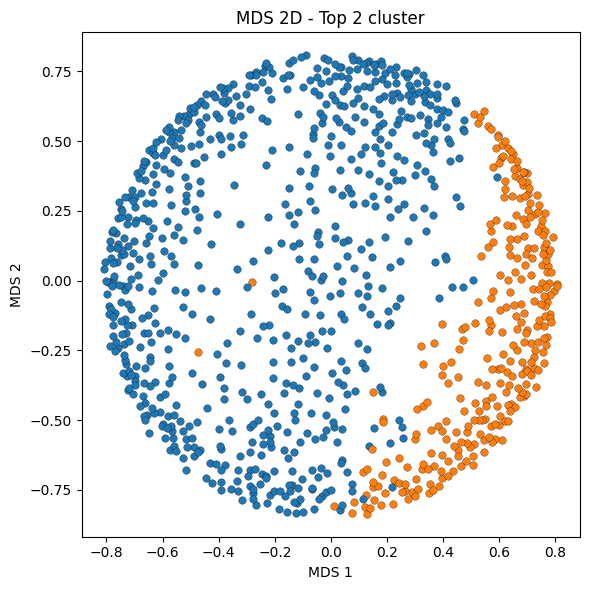

[INFO] Genero miniature per ciascun cluster di 'brain_glioma' …
[INFO] Cluster 0: 715 immagini trovate


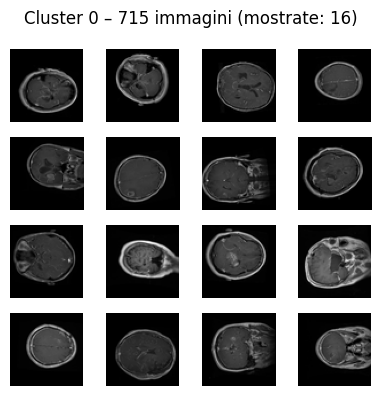

[INFO] Cluster 1: 287 immagini trovate


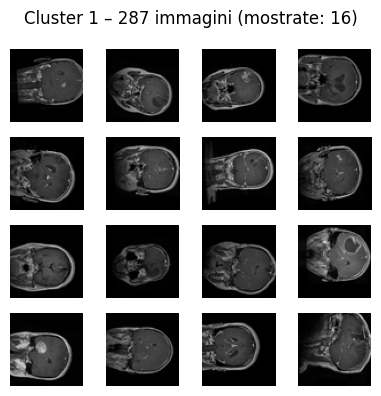


[INFO] Elaboro label: brain_menin
Applicazione di umap -> Riduzione a 50 componenti


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[INFO] Cluster-labels trovati: [0]
[WARN] DBSCAN ha trovato solo 1 cluster (meno di 3).
[INFO] Top 3 cluster (per dimensione): [0]
[INFO] Disegno MDS 2D per i cluster di 'brain_menin' …


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


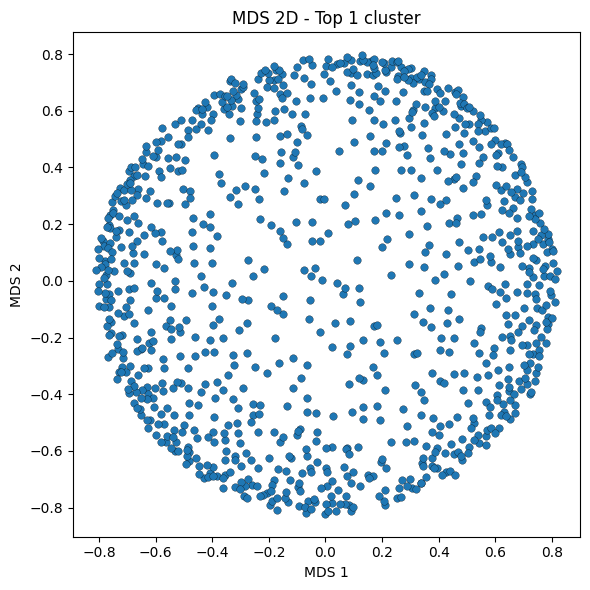

[INFO] Genero miniature per ciascun cluster di 'brain_menin' …
[INFO] Cluster 0: 1002 immagini trovate


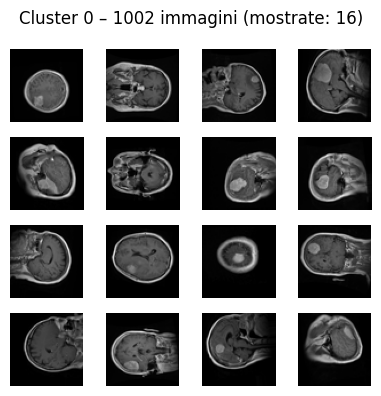


[INFO] Elaboro label: brain_tumor
Applicazione di umap -> Riduzione a 50 componenti


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[INFO] Cluster-labels trovati: [0]
[WARN] DBSCAN ha trovato solo 1 cluster (meno di 3).
[INFO] Top 3 cluster (per dimensione): [0]
[INFO] Disegno MDS 2D per i cluster di 'brain_tumor' …


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


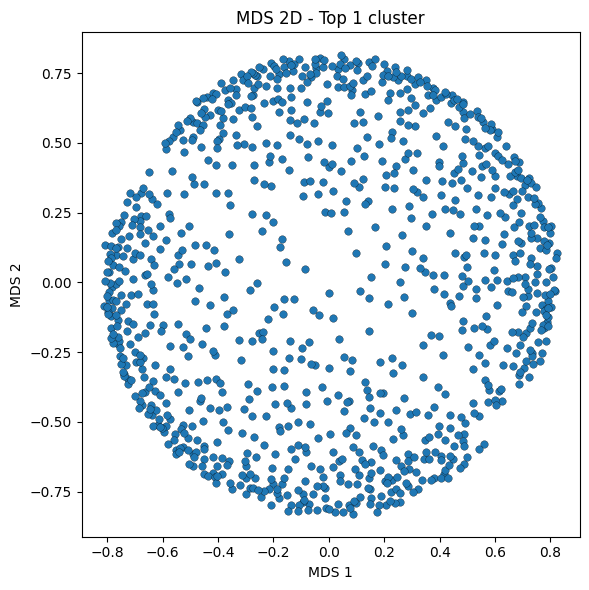

[INFO] Genero miniature per ciascun cluster di 'brain_tumor' …
[INFO] Cluster 0: 1002 immagini trovate


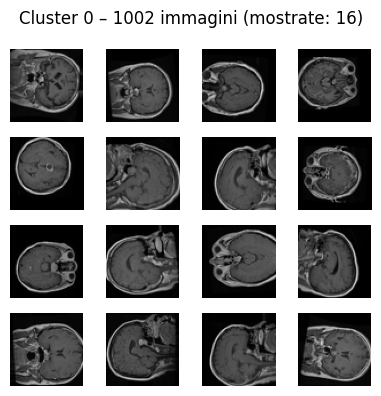


[FINITO] Task 8 completato per tutte le label di Parte1.


In [31]:
eps = 5.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label
method = 'umap'      # umap or pca
db_scan_detection(eps, min_samples, n_components, c, method)

# Task 9 - Classificazione Supervisionata con k-NN e Decision Tree

Implementa un programma che, date le immagini della **Parte 1**:

- Crei un classificatore **m-NN** (con **m** specificato dall'utente).
- Crei un classificatore basato su **albero decisionale**.

Per questo task puoi utilizzare **lo spazio delle feature a tua scelta**.

Il programma deve poi:
- Applicare il classificatore selezionato dall'utente per prevedere le etichette più probabili delle immagini della **Parte 2**.
- Calcolare e visualizzare:
  - **Precisione (Precision)** per etichetta,
  - **Richiamo (Recall)** per etichetta,
  - **Punteggio F1 (F1-score)** per etichetta,
  - **Accuratezza complessiva (Accuracy)** del classificatore.

## Obiettivo del Task

In questo task testiamo due approcci di **classificazione supervisionata**, usando come feature i **Color Moments** estratti in precedenza.  
L’obiettivo è **prevedere la classe** di ciascuna immagine del dataset **Parte 2**, dopo aver addestrato i classificatori sulla **Parte 1**.

---

## Classificatori utilizzati

### 1️ **k-NN (k Nearest Neighbors)**

- Ogni immagine viene classificata in base alla **classe più rappresentata tra i suoi k vicini più vicini** nello spazio delle feature.
- Semplice ed efficace per spazi vettoriali ridotti.

Parametri usati:
- **k = 5**, valore bilanciato che riduce il rischio di overfitting.

---

### 2️ **Decision Tree**

- Crea un **albero decisionale** che suddivide lo spazio delle feature in base a soglie ottimali per separare le classi.
- Modello interpretabile ma potenzialmente sensibile al rumore.

Parametri usati:
- Parametri di default → l’albero viene costruito senza limitazioni particolari sulla profondità.

---

## Metodo

1. **Training:**
   - I classificatori vengono addestrati sulle feature del dataset **Parte 1**, per ciascuna immagine e classe nota.
2. **Testing:**
   - I modelli vengono testati sulle feature delle immagini della **Parte 2**, simulando un vero scenario di classificazione.

---

## **Risultati – k-NN (k = 5)**

| Classe         | Precisione | Recall | F1-score |
|----------------|------------|--------|----------|
| brain_glioma   | 0.78       | 0.85   | 0.81     |
| brain_menin    | 0.84       | 0.63   | 0.72     |
| brain_tumor    | 0.74       | 0.85   | 0.79     |

**Accuratezza complessiva:** **77.7%**

### Analisi:
- La classe **brain_glioma** viene riconosciuta bene (**85% recall**).
- La classe **brain_menin** è più difficile da riconoscere (**63% recall**), anche se la precisione è alta.
- La classe **brain_tumor** mostra un buon bilanciamento tra precisione e recall.

Nel complesso, il k-NN ha ottenuto **buoni risultati**, grazie alla semplicità ed efficacia in spazi di feature ridotti.

---

## **Risultati – Decision Tree**

| Classe         | Precisione | Recall | F1-score |
|----------------|------------|--------|----------|
| brain_glioma   | 0.75       | 0.76   | 0.75     |
| brain_menin    | 0.64       | 0.62   | 0.63     |
| brain_tumor    | 0.71       | 0.72   | 0.71     |

**Accuratezza complessiva:** **70%**

### Analisi:
- Le prestazioni sono inferiori rispetto al k-NN su tutte le classi.
- Il Decision Tree ottiene un comportamento **equilibrato**, ma globalmente meno performante.

---

## Confronto tra i due modelli

| Modello        | Accuracy | Precisione media | Recall medio | F1-score medio | Classe più riconosciuta | Classe più difficile |
|----------------|----------|------------------|--------------|----------------|------------------------|----------------------|
| **k-NN (k=5)** | 77.7%    | 78%              | 78%          | 77%            | brain_glioma (85% recall) | brain_menin (63% recall) |
| **Decision Tree** | 70.0%    | 70%              | 70%          | 70%            | brain_glioma (76% recall) | brain_menin (62% recall) |

**Conclusioni del confronto:**
- Il **k-NN** è il classificatore migliore in questo scenario, probabilmente grazie alla sua capacità di sfruttare la **distribuzione locale** delle feature.
- Il **Decision Tree**, pur essendo più interpretabile, sembra soffrire di più la **complessità e il rumore** nei dati.

---

## Conclusioni del Task 9

- Con algoritmi **semplici**, come k-NN e Decision Tree, si ottengono già **buoni risultati di base**.
- La classe **brain_menin** rimane la più difficile da riconoscere, suggerendo che le sue feature non sono ben distinte dalle altre classi.
- Il dataset, nonostante la riduzione dimensionale e la pulizia dei dati, richiede probabilmente **modelli più sofisticati** per raggiungere performance elevate (es. Random Forest, SVM, o modelli deep learning).

In [ ]:
# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))

# Task 10: Locality Sensitive Hashing e Ricerca di Immagini Simili

## 10a: Creazione dell'indice LSH

Implementa uno strumento di **Locality Sensitive Hashing (LSH)** (per la distanza euclidea), che prende come input:
- **L**: Numero di livelli,
- **h**: Numero di hash per livello,
- Un insieme di vettori (feature delle immagini).

Il programma deve creare **una struttura di indice in memoria** contenente l'insieme di vettori dato.

> Riferimento:  
> "Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions",  
> Alexandr Andoni e Piotr Indyk, *Communications of the ACM*, vol. 51, no. 1, 2008, pp. 117–122.

---

## 10b: Ricerca di immagini simili con LSH

Implementa un algoritmo di ricerca di immagini simili utilizzando la struttura LSH creata in 11a, memorizzando le immagini della **Parte 1** e un modello visivo di tua scelta (**il modello visivo combinato deve avere almeno 256 dimensioni**).

Per una data immagine di query e un numero intero **t**, il programma deve:

- Visualizzare le **t immagini più simili**.
- Mostrare:
  - Il **numero di immagini uniche** considerate,
  - Il **numero totale di immagini analizzate** durante il processo.


  

## Obiettivo del Task

Fino ad ora abbiamo calcolato la similarità tra immagini confrontando la query con tutte le immagini del dataset.  
Questo approccio è efficace, ma **computazionalmente molto costoso**, soprattutto per dataset di grandi dimensioni.

In questo task introduciamo il **Locality Sensitive Hashing (LSH)**, una tecnica che consente di **ridurre il numero di confronti**, accelerando la ricerca delle immagini simili.

---

## Cos'è il Locality Sensitive Hashing (LSH)?

LSH è una tecnica che:
- Indicizza i vettori in modo che quelli **simili abbiano alta probabilità di finire nello stesso bucket**;
- I vettori distanti finiscono in bucket diversi, evitando confronti inutili.

### Vantaggi principali
- Ricerca **approssimata**, ma molto veloce.
- Buon compromesso tra **accuratezza e tempo di calcolo**, soprattutto su dataset grandi.

---

## Metodo adottato

### 1 Creazione dell’indice LSH

Abbiamo implementato un indice chiamato **LSH_EuclideanQuantized**, progettato per la **distanza Euclidea**.  
Ogni vettore viene:
- **centrato**, sottraendo la media globale,
- **normalizzato** a norma unitaria (**L2 norm**).

| Parametro | Significato                                                | Valore utilizzato |
|-----------|------------------------------------------------------------|--------------------|
| **D**     | Dimensione dei vettori (Color Moments)                      | 900                |
| **L**     | Numero di livelli hash (più livelli = maggiore affidabilità)| 5                  |
| **h**     | Numero di funzioni hash per livello                         | 5                  |
| **r**     | Larghezza dei bucket hash (controlla la granularità)        | 5.0                |

---

### 2️ Ricerca della query

Per cercare immagini simili a una query:
- Si estrae il vettore dei Color Moments,
- Si centra e normalizza con gli stessi parametri del training,
- Si cercano i bucket hash più rilevanti (in tutti i livelli hash),
- Si calcolano le **distanze Euclidee reali** solo con i candidati recuperati dai bucket.

---

## Esempio completo di risultati ottenuti

Abbiamo cercato le **5 immagini più simili** a:
I risultati ottenuti sono i seguenti:

| #  | Nome File              | Classe        | Distanza Euclidea |
|----|------------------------|---------------|-------------------|
| 1  | brain_glioma_0596.jpg  | brain_glioma  | 0.66              |
| 2  | brain_menin_0554.jpg   | brain_menin   | 0.87              |
| 3  | brain_tumor_0622.jpg   | brain_tumor   | 0.89              |
| 4  | brain_menin_0585.jpg   | brain_menin   | 0.93              |
| 5  | brain_menin_0520.jpg   | brain_menin   | 0.93              |

---

### Analisi dei risultati

- I primi risultati includono correttamente immagini della classe **brain_menin**, anche se il primo risultato è un **brain_glioma** → questo riflette le **limitazioni dei Color Moments**, che non separano perfettamente le classi.
- La **distanza Euclidea** tra query e immagini trovate è abbastanza bassa (<1), segno che i risultati sono visivamente simili.
- L’LSH ha evitato di confrontare l’intero dataset:
  - Immagini **uniche** considerate: **2442**
  - Immagini **totali** processate (su tutti i livelli hash): **4055**
  
Senza LSH avremmo dovuto confrontare circa **3000 immagini**, quindi l’efficienza è migliorata notevolmente.

---

## Parametri suggeriti per LSH (dai test)

| Parametro | Range consigliato | Effetti |
|-----------|--------------------|---------|
| **L**     | 5 - 8              | Aumenta l'affidabilità, ma anche il costo computazionale |
| **h**     | 4 - 8              | Più hash function → bucket più precisi |
| **r**     | 3.0 - 7.0          | Bucket larghi → risultati più approssimati; bucket stretti → meno candidati trovati |

---

## Conclusioni del Task 10

|  Pro                                                 |  Contro                                                |
|--------------------------------------------------------|----------------------------------------------------------|
| Ricerca molto più veloce rispetto al confronto esaustivo | I risultati sono approssimati, non sempre perfetti       |
| Riduzione drastica dei confronti                        | Richiede tuning fine dei parametri (L, h, r)            |
| Utile su dataset grandi e ad alta dimensionalità        | Potrebbe non funzionare bene con dati molto disomogenei |

---

### Riflessioni finali

- LSH dimostra di essere una **soluzione efficace** per accelerare il retrieval su dataset numerosi.
- Non sostituisce il confronto esaustivo in termini di precisione assoluta, ma ne riduce enormemente i costi computazionali.
- In ambito medico può essere utilizzato per ottenere **risultati preliminari rapidi**, eventualmente raffinati successivamente.


In [23]:
class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea con quantizzazione (p-stable).
    num_layers = L, num_hashes = h, dim = D, r = bucket width.
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        self.hash_tables = [defaultdict(list) for _ in range(self.L)]
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        bits = []
        for j in range(self.h):
            a_j = self.a_vectors[layer_idx][j]
            b_j = self.b_offsets[layer_idx][j]
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            bits.append(h_val)
        return tuple(bits)

    def index(self, vectors: np.ndarray):
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Dimensione vettore ({D}) ≠ D di LSH ({self.d})."
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        assert q_vec.shape[0] == self.d, "Dimensione query ≠ D."
        candidati = set()
        total_checked = 0
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked


In [ ]:
# 1) Center + L2 normalize su Part1
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH con quantizzazione
D = feat_normed.shape[1]      # ad esempio 900
L = 5                         # numero di layer (esempio)
h = 5                        # numero di hash per layer (esempio)
r = 5.0                       # bucket width, da sperimentare

# 3) Creo l'indice
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] Indice LSH-Quant creato. D={D}, L={L}, h={h}, r={r}")



In [48]:
def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Trova le k immagini più simili a img_path (di Part2) usando lsh_quant costruito su Part1.
    """
    # 1) Estrai feature raw (900-dim)
    raw_q = np.array(extract_color_moments(img_path), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec usato su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampo i risultati testuali
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_menin/brain_menin_1003.jpg"

print(query_path);
k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)
